(35.0, 50.0)

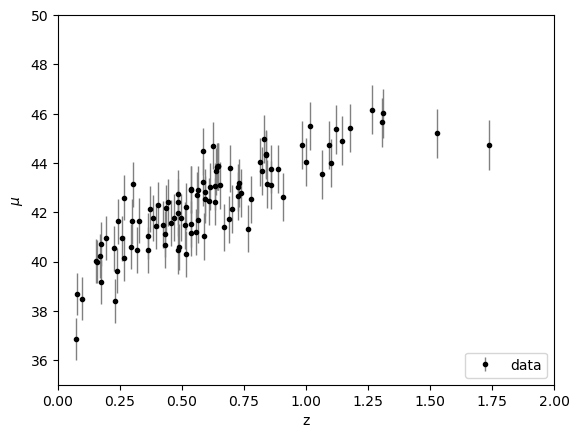

In [7]:
from astroML.datasets import generate_mu_z
import matplotlib.pyplot as plt
import numpy as np

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) # YOU CANNOT CHANGE THIS

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

/opt/anaconda3/envs/Tesi/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/Tesi/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/Tesi/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/Tesi/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


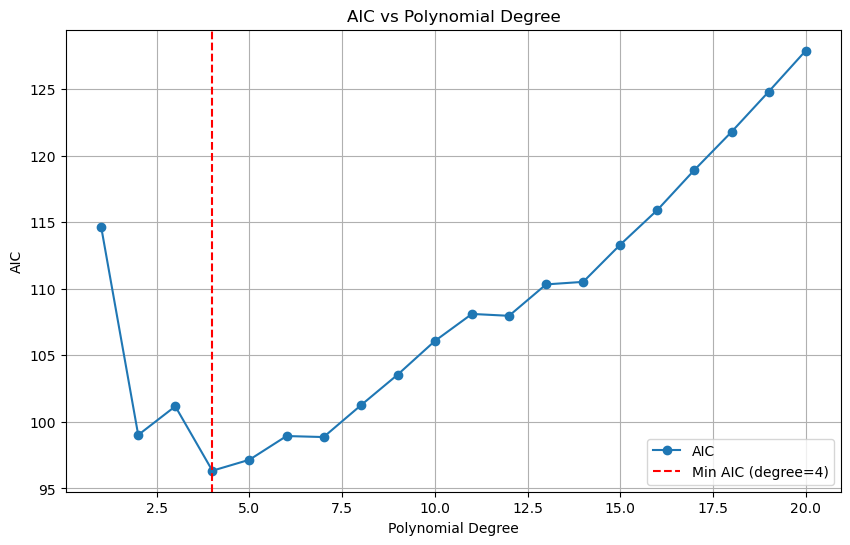

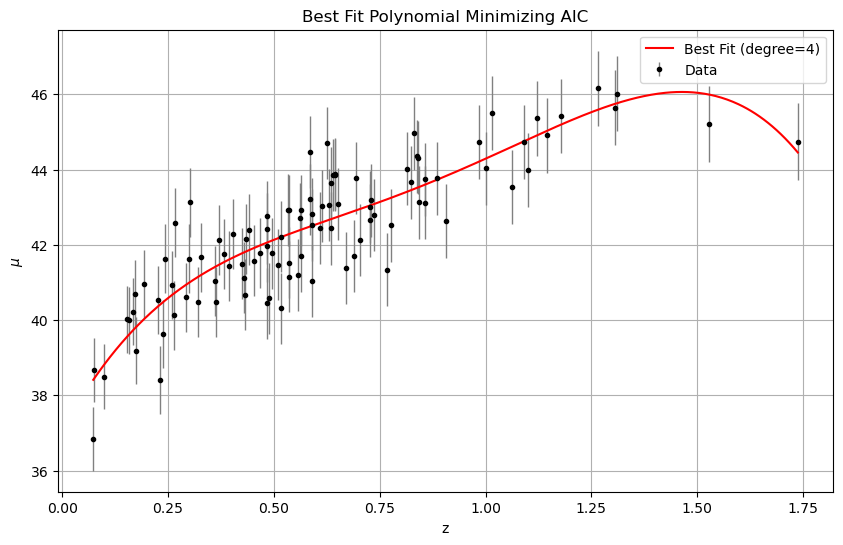

The degree with the minimum AIC is: 4


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import generate_mu_z

# Lista per salvare i valori di AIC
aic_values = []

# Gradi dei polinomi
degrees = range(1, 21)

# Loop sui gradi
for degree in degrees:
    # Fit del polinomio
    coeffs = np.polyfit(z_sample, mu_sample, degree, w=1/dmu)
    poly = np.poly1d(coeffs)
    
    # Predizioni
    mu_pred = poly(z_sample)
    
    # Calcolo dell'AIC
    n = len(mu_sample)
    k = degree + 1  # Numero di parametri (coefficiente per ogni grado + intercetta)
    resid = mu_sample - mu_pred
    chi2 = np.sum((resid / dmu) ** 2)

    AIC = chi2 + 2 * k + ((2*k*(k+1))/(n-k-1))
    aic_values.append(AIC)

# Trova il grado con AIC minimo
best_degree = degrees[np.argmin(aic_values)]

# Plot dell'AIC in funzione del grado
plt.figure(figsize=(10, 6))
plt.plot(degrees, aic_values, marker='o', label='AIC')
plt.axvline(best_degree, color='r', linestyle='--', label=f'Min AIC (degree={best_degree})')
plt.xlabel('Polynomial Degree')
plt.ylabel('AIC')
plt.title('AIC vs Polynomial Degree')
plt.legend()
plt.grid()
plt.show()

# Fit the polynomial with the best degree
best_coeffs = np.polyfit(z_sample, mu_sample, best_degree)
best_poly = np.poly1d(best_coeffs)

# Generate predictions
z_fit = np.linspace(min(z_sample), max(z_sample), 500)
mu_fit = best_poly(z_fit)

# Plot the data and the best fit
plt.figure(figsize=(10, 6))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')
plt.plot(z_fit, mu_fit, 'r-', label=f'Best Fit (degree={best_degree})')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title("Best Fit Polynomial Minimizing AIC")
plt.legend()
plt.grid()
plt.show()

print(f"The degree with the minimum AIC is: {best_degree}")

In [9]:
from sklearn.model_selection import train_test_split

X = z_sample[:, np.newaxis]
y = mu_sample

X_train, X_val, y_train, y_val, dmu_train, dmu_val = train_test_split(X, y, dmu, test_size=0.2, random_state=42)


Best polynomial degree from CV: 2


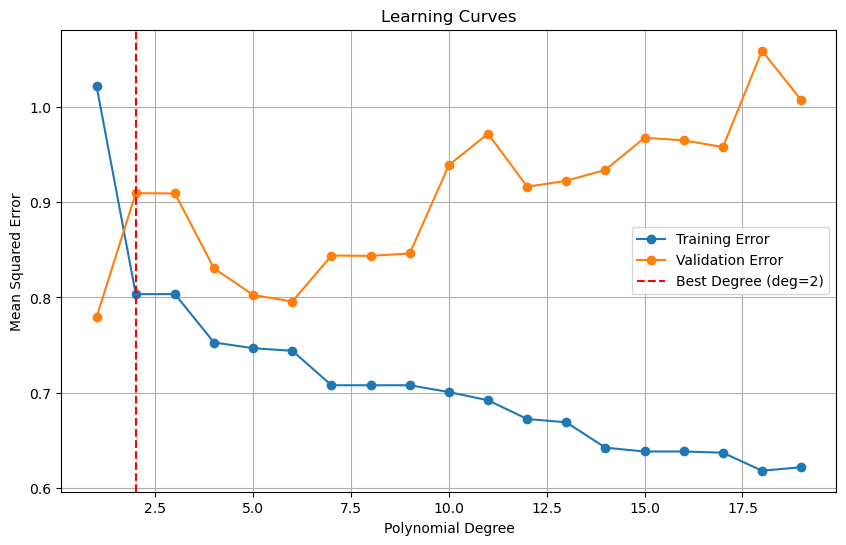

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

degrees = np.arange(1, 20)
val_scores = []

for deg in degrees:
    model = make_pipeline(PolynomialFeatures(deg), LinearRegression())
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    val_scores.append(-scores.mean())

best_degree = degrees[np.argmin(val_scores)]
print(f"Best polynomial degree from CV: {best_degree}")

train_scores = []
val_scores = []

for deg in degrees:
    model = make_pipeline(PolynomialFeatures(deg), LinearRegression())
    model.fit(X_train, y_train)
    
    # Compute training score
    train_pred = model.predict(X_train)
    train_scores.append(np.mean((train_pred - y_train) ** 2))
    
    # Compute validation score
    val_pred = model.predict(X_val)
    val_scores.append(np.mean((val_pred - y_val) ** 2))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_scores, label="Training Error", marker='o')
plt.plot(degrees, val_scores, label="Validation Error", marker='o')
plt.axvline(best_degree, color='r', linestyle='--', label=f'Best Degree (deg={best_degree})')
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curves")
plt.legend()
plt.grid()
plt.show()

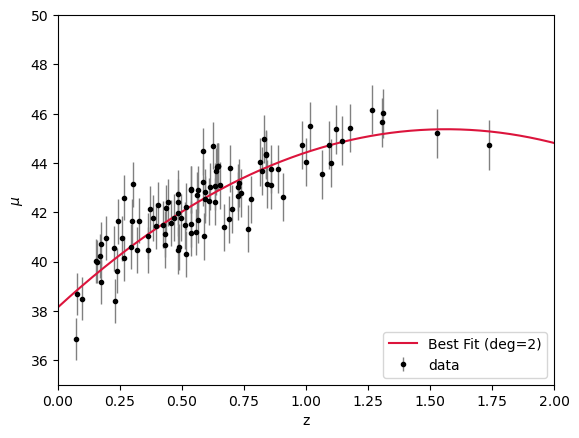

In [11]:
# Fit on full training set
best_model = make_pipeline(PolynomialFeatures(best_degree), LinearRegression())
best_model.fit(X_train, y_train)

# Predict on fine grid for plotting
z_plot = np.linspace(0, 2, 1000)[:, None]
mu_pred = best_model.predict(z_plot)

# Plot result
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(z_plot, mu_pred, label=f'Best Fit (deg={best_degree})', color='crimson')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()


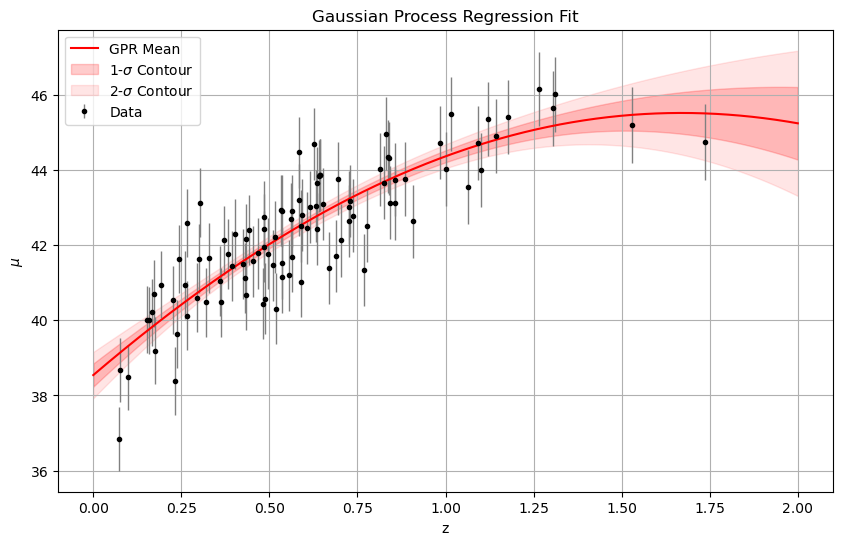

Optimized kernel: 30.7**2 * RBF(length_scale=3.9)


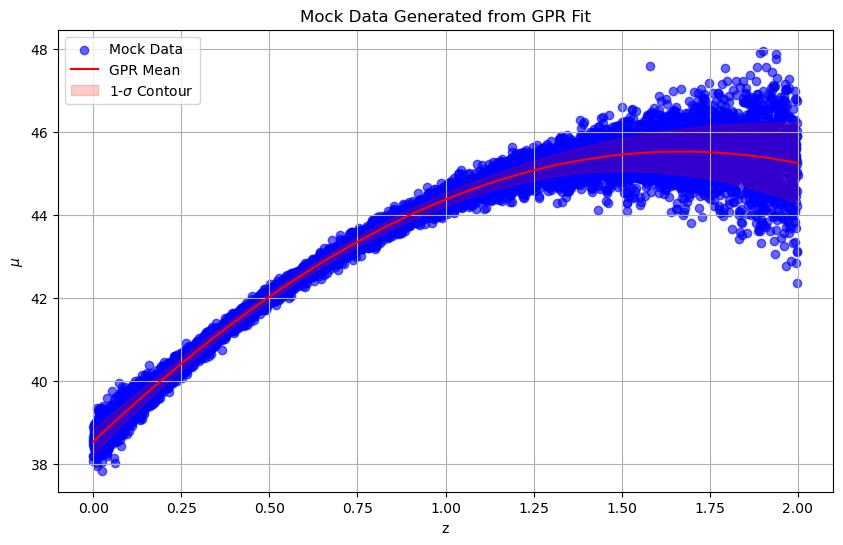

In [21]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Define the kernel: RBF kernel with a constant kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize the Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2, n_restarts_optimizer=10, random_state=42)

# Fit the GPR model to the data
gpr.fit(z_sample[:, np.newaxis], mu_sample)

# Predict the mean and standard deviation of the GPR fit
mu_pred, sigma = gpr.predict(z_plot, return_std=True)

# Plot the results
plt.figure(figsize=(10, 6))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')
plt.plot(z_plot, mu_pred, 'r-', label='GPR Mean')
plt.fill_between(z_plot.ravel(), mu_pred - sigma, mu_pred + sigma, color='r', alpha=0.2, label='1-$\sigma$ Contour')
plt.fill_between(z_plot.ravel(), mu_pred - 2 * sigma, mu_pred + 2 * sigma, color='r', alpha=0.1, label='2-$\sigma$ Contour')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title("Gaussian Process Regression Fit")
plt.legend()
plt.grid()
plt.show()

# Print the kernel and its optimized parameters
print(f"Optimized kernel: {gpr.kernel_}")

# Generate mock data based on the GPR fit
np.random.seed(42)  # For reproducibility
mock_z = np.sort(np.random.uniform(0, 2, 10000))[:, None]  # Generate 100 random z values in the range [0, 2]
mock_mu, mock_sigma = gpr.predict(mock_z, return_std=True)  # Predict mean and std from GPR
mock_mu += np.random.normal(0, mock_sigma)  # Add Gaussian noise based on predicted std

# Plot the mock data
plt.figure(figsize=(10, 6))
plt.scatter(mock_z, mock_mu, color='blue', label='Mock Data', alpha=0.6)
plt.plot(z_plot, mu_pred, 'r-', label='GPR Mean')
plt.fill_between(z_plot.ravel(), mu_pred - sigma, mu_pred + sigma, color='r', alpha=0.2, label='1-$\sigma$ Contour')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title("Mock Data Generated from GPR Fit")
plt.legend()
plt.grid()
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[0.07346547 0.07680011 0.08013475 0.08346939 0.08680403 0.09013867
 0.09347331 0.09680795 0.10014259 0.10347723 0.10681187 0.11014651
 0.11348115 0.11681579 0.12015043 0.12348507 0.12681971 0.13015435
 0.13348899 0.13682363 0.14015827 0.14349291 0.14682755 0.15016219
 0.15349682 0.15683146 0.1601661  0.16350074 0.16683538 0.17017002
 0.17350466 0.1768393  0.18017394 0.18350858 0.18684322 0.19017786
 0.1935125  0.19684714 0.20018178 0.20351642 0.20685106 0.2101857
 0.21352034 0.21685498 0.22018962 0.22352426 0.2268589  0.23019354
 0.23352818 0.23686282 0.24019746 0.2435321  0.24686674 0.25020138
 0.25353602 0.25687066 0.2602053  0.26353994 0.26687458 0.27020922
 0.27354386 0.2768785  0.28021314 0.28354777 0.28688241 0.29021705
 0.29355169 0.29688633 0.30022097 0.30355561 0.30689025 0.31022489
 0.31355953 0.31689417 0.32022881 0.32356345 0.32689809 0.33023273
 0.33356737 0.33690201 0.34023665 0.34357129 0.34690593 0.35024057
 0.35357521 0.35690985 0.36024449 0.36357913 0.36691377 0.37024841
 0.37358305 0.37691769 0.38025233 0.38358697 0.38692161 0.39025625
 0.39359089 0.39692553 0.40026017 0.40359481 0.40692945 0.41026408
 0.41359872 0.41693336 0.420268   0.42360264 0.42693728 0.43027192
 0.43360656 0.4369412  0.44027584 0.44361048 0.44694512 0.45027976
 0.4536144  0.45694904 0.46028368 0.46361832 0.46695296 0.4702876
 0.47362224 0.47695688 0.48029152 0.48362616 0.4869608  0.49029544
 0.49363008 0.49696472 0.50029936 0.503634   0.50696864 0.51030328
 0.51363792 0.51697256 0.5203072  0.52364184 0.52697648 0.53031112
 0.53364576 0.5369804  0.54031503 0.54364967 0.54698431 0.55031895
 0.55365359 0.55698823 0.56032287 0.56365751 0.56699215 0.57032679
 0.57366143 0.57699607 0.58033071 0.58366535 0.58699999 0.59033463
 0.59366927 0.59700391 0.60033855 0.60367319 0.60700783 0.61034247
 0.61367711 0.61701175 0.62034639 0.62368103 0.62701567 0.63035031
 0.63368495 0.63701959 0.64035423 0.64368887 0.64702351 0.65035815
 0.65369279 0.65702743 0.66036207 0.66369671 0.66703134 0.67036598
 0.67370062 0.67703526 0.6803699  0.68370454 0.68703918 0.69037382
 0.69370846 0.6970431  0.70037774 0.70371238 0.70704702 0.71038166
 0.7137163  0.71705094 0.72038558 0.72372022 0.72705486 0.7303895
 0.73372414 0.73705878 0.74039342 0.74372806 0.7470627  0.75039734
 0.75373198 0.75706662 0.76040126 0.7637359  0.76707054 0.77040518
 0.77373982 0.77707446 0.7804091  0.78374374 0.78707838 0.79041302
 0.79374766 0.79708229 0.80041693 0.80375157 0.80708621 0.81042085
 0.81375549 0.81709013 0.82042477 0.82375941 0.82709405 0.83042869
 0.83376333 0.83709797 0.84043261 0.84376725 0.84710189 0.85043653
 0.85377117 0.85710581 0.86044045 0.86377509 0.86710973 0.87044437
 0.87377901 0.87711365 0.88044829 0.88378293 0.88711757 0.89045221
 0.89378685 0.89712149 0.90045613 0.90379077 0.90712541 0.91046005
 0.91379469 0.91712933 0.92046397 0.9237986  0.92713324 0.93046788
 0.93380252 0.93713716 0.9404718  0.94380644 0.94714108 0.95047572
 0.95381036 0.957145   0.96047964 0.96381428 0.96714892 0.97048356
 0.9738182  0.97715284 0.98048748 0.98382212 0.98715676 0.9904914
 0.99382604 0.99716068 1.00049532 1.00382996 1.0071646  1.01049924
 1.01383388 1.01716852 1.02050316 1.0238378  1.02717244 1.03050708
 1.03384172 1.03717636 1.040511   1.04384564 1.04718028 1.05051492
 1.05384955 1.05718419 1.06051883 1.06385347 1.06718811 1.07052275
 1.07385739 1.07719203 1.08052667 1.08386131 1.08719595 1.09053059
 1.09386523 1.09719987 1.10053451 1.10386915 1.10720379 1.11053843
 1.11387307 1.11720771 1.12054235 1.12387699 1.12721163 1.13054627
 1.13388091 1.13721555 1.14055019 1.14388483 1.14721947 1.15055411
 1.15388875 1.15722339 1.16055803 1.16389267 1.16722731 1.17056195
 1.17389659 1.17723123 1.18056586 1.1839005  1.18723514 1.19056978
 1.19390442 1.19723906 1.2005737  1.20390834 1.20724298 1.21057762
 1.21391226 1.2172469  1.22058154 1.22391618 1.22725082 1.23058546
 1.2339201  1.23725474 1.24058938 1.24392402 1.24725866 1.2505933
 1.25392794 1.25726258 1.26059722 1.26393186 1.2672665  1.27060114
 1.27393578 1.27727042 1.28060506 1.2839397  1.28727434 1.29060898
 1.29394362 1.29727826 1.3006129  1.30394754 1.30728218 1.31061681
 1.31395145 1.31728609 1.32062073 1.32395537 1.32729001 1.33062465
 1.33395929 1.33729393 1.34062857 1.34396321 1.34729785 1.35063249
 1.35396713 1.35730177 1.36063641 1.36397105 1.36730569 1.37064033
 1.37397497 1.37730961 1.38064425 1.38397889 1.38731353 1.39064817
 1.39398281 1.39731745 1.40065209 1.40398673 1.40732137 1.41065601
 1.41399065 1.41732529 1.42065993 1.42399457 1.42732921 1.43066385
 1.43399849 1.43733312 1.44066776 1.4440024  1.44733704 1.45067168
 1.45400632 1.45734096 1.4606756  1.46401024 1.46734488 1.47067952
 1.47401416 1.4773488  1.48068344 1.48401808 1.48735272 1.49068736
 1.494022   1.49735664 1.50069128 1.50402592 1.50736056 1.5106952
 1.51402984 1.51736448 1.52069912 1.52403376 1.5273684  1.53070304
 1.53403768 1.53737232 1.54070696 1.5440416  1.54737624 1.55071088
 1.55404552 1.55738016 1.5607148  1.56404944 1.56738407 1.57071871
 1.57405335 1.57738799 1.58072263 1.58405727 1.58739191 1.59072655
 1.59406119 1.59739583 1.60073047 1.60406511 1.60739975 1.61073439
 1.61406903 1.61740367 1.62073831 1.62407295 1.62740759 1.63074223
 1.63407687 1.63741151 1.64074615 1.64408079 1.64741543 1.65075007
 1.65408471 1.65741935 1.66075399 1.66408863 1.66742327 1.67075791
 1.67409255 1.67742719 1.68076183 1.68409647 1.68743111 1.69076575
 1.69410038 1.69743502 1.70076966 1.7041043  1.70743894 1.71077358
 1.71410822 1.71744286 1.7207775  1.72411214 1.72744678 1.73078142
 1.73411606 1.7374507 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

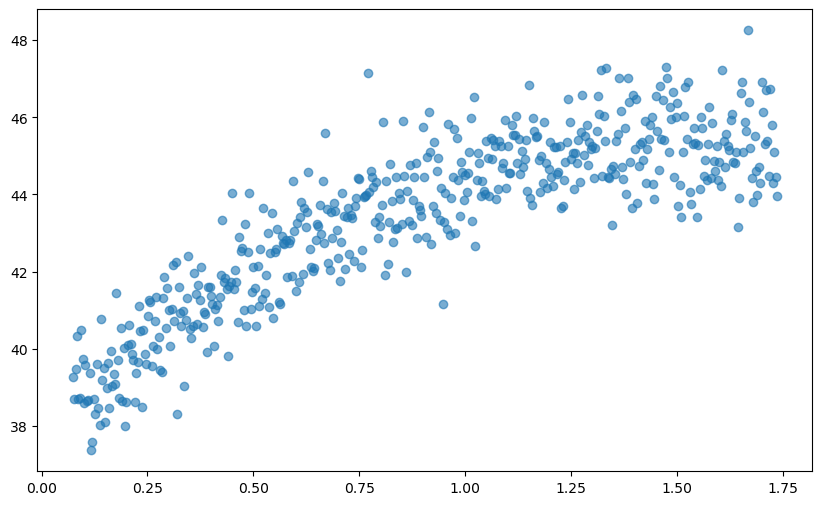